In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
import scipy.integrate
from scipy.signal import find_peaks

In [4]:
# Define file paths (Update these paths to match your local file locations)
file_paths = {
    "Left Thigh": "./dataset_formatted/patient1/test5/LT.csv",
    "Right Thigh": "./dataset_formatted/patient1/test5/RT.csv",
    "Left Shank": "./dataset_formatted/patient1/test5/LS.csv",
    "Right Shank": "./dataset_formatted/patient1/test5/RS.csv",
    "Left Ankle": "./dataset_formatted/patient1/test5/LA.csv",
    "Right Ankle": "./dataset_formatted/patient1/test5/RA.csv",
}

In [5]:
# Load all sensor data into a dictionary
sensor_data = {}
for label, path in file_paths.items():
    sensor_data[label] = pd.read_csv(path)

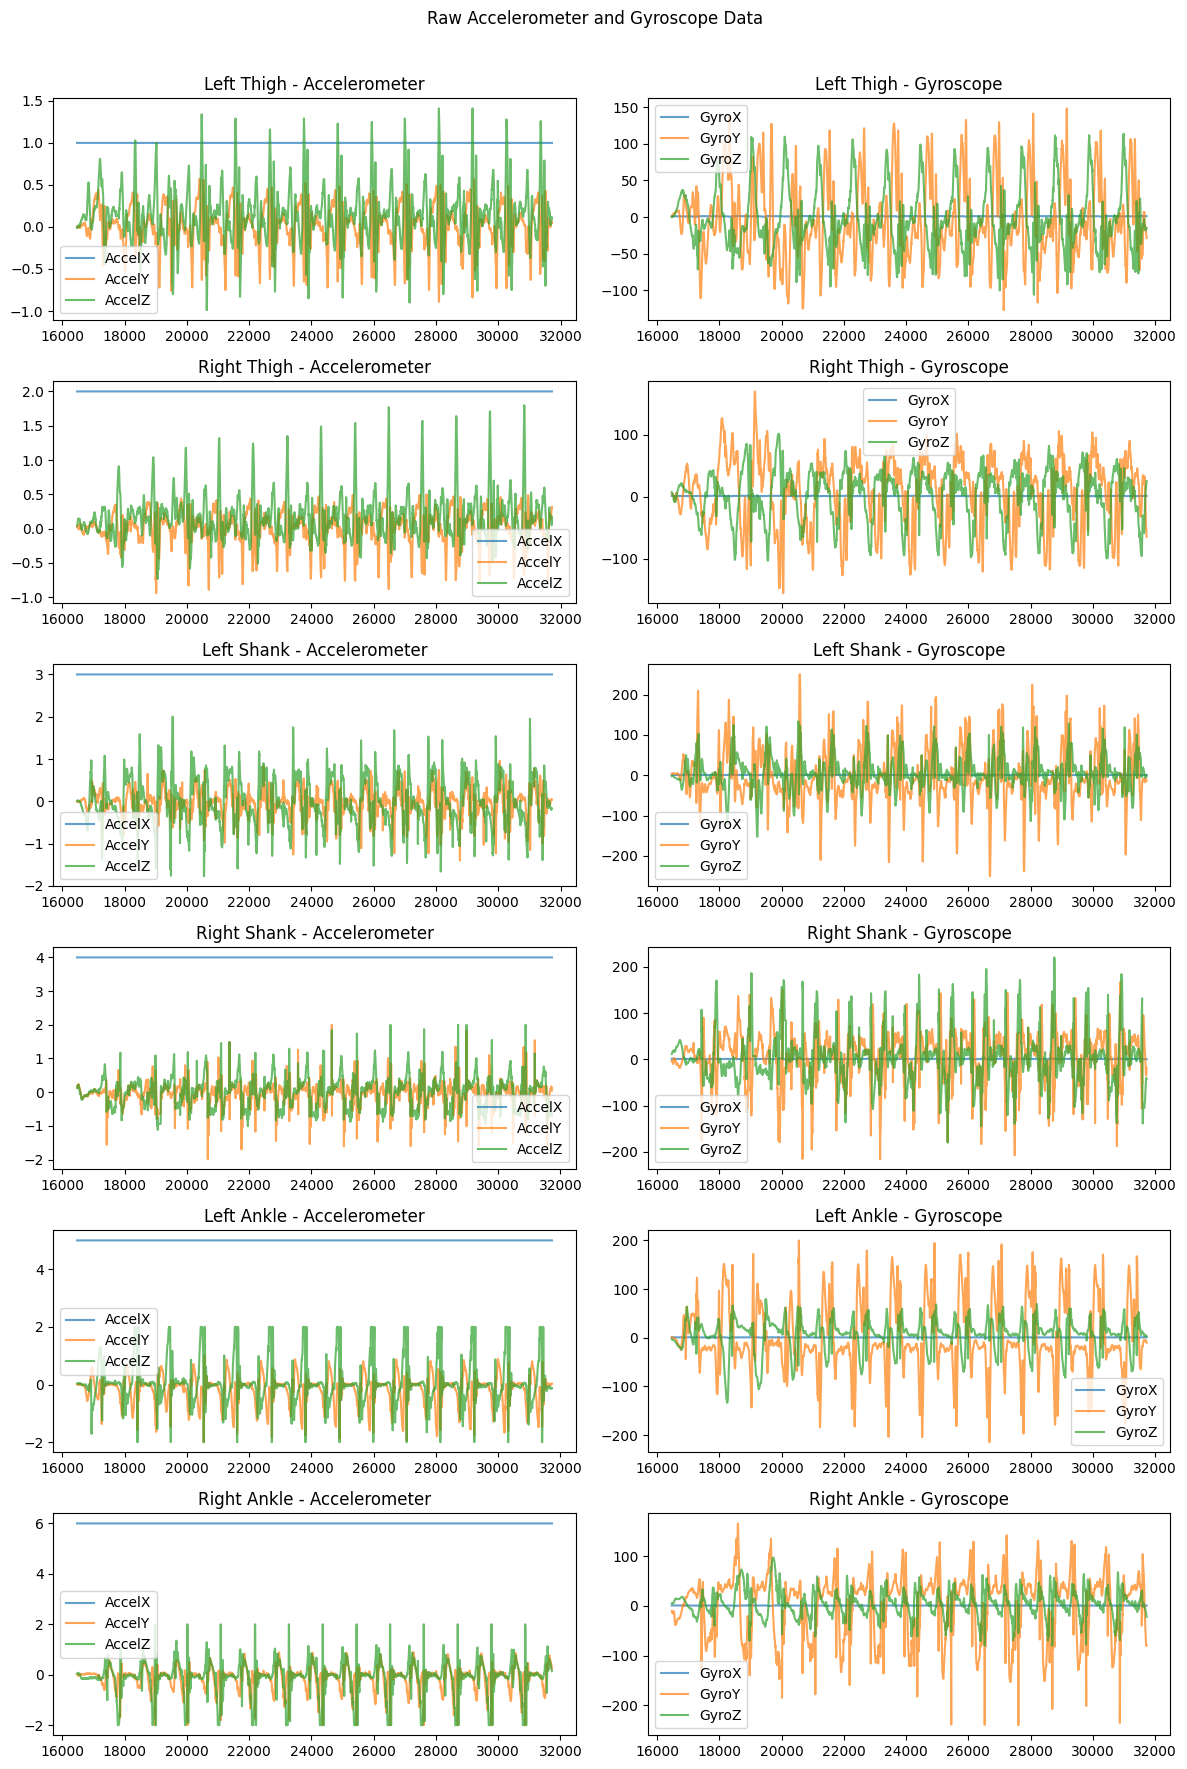

In [6]:
# Plot raw accelerometer and gyroscope data
fig, axes = plt.subplots(6, 2, figsize=(12, 18))
fig.suptitle("Raw Accelerometer and Gyroscope Data")

for i, (label, df) in enumerate(sensor_data.items()):
    time = df.iloc[:, 0]  # Time column
    axes[i, 0].plot(time, df.iloc[:, 1], label="AccelX", alpha=0.7)
    axes[i, 0].plot(time, df.iloc[:, 2], label="AccelY", alpha=0.7)
    axes[i, 0].plot(time, df.iloc[:, 3], label="AccelZ", alpha=0.7)
    axes[i, 0].set_title(f"{label} - Accelerometer")
    axes[i, 0].legend()
    
    axes[i, 1].plot(time, df.iloc[:, 4], label="GyroX", alpha=0.7)
    axes[i, 1].plot(time, df.iloc[:, 5], label="GyroY", alpha=0.7)
    axes[i, 1].plot(time, df.iloc[:, 6], label="GyroZ", alpha=0.7)
    axes[i, 1].set_title(f"{label} - Gyroscope")
    axes[i, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [8]:
print(sensor_data)

{'Left Thigh':       Time(ms)  SensorID  AccelX  AccelY  AccelZ  GyroX  GyroY  GyroZ
0        16472         1    0.00   -0.01    1.04   0.82   0.04  -6.51
1        16478         1   -0.01    0.01    1.04   1.29   0.30  -6.53
2        16483         1    0.00    0.00    1.05   2.03   0.57  -6.56
3        16488         1   -0.01    0.00    1.05   2.38   0.27  -6.80
4        16493         1   -0.00    0.00    1.07   2.56   0.21  -6.75
...        ...       ...     ...     ...     ...    ...    ...    ...
3046     31703         1    0.04    0.06    1.13 -21.37 -17.22 -51.61
3047     31708         1    0.06    0.09    1.17 -22.63 -16.31 -51.44
3048     31713         1    0.06    0.12    1.17 -23.90 -15.81 -50.67
3049     31718         1    0.05    0.11    1.17 -25.18 -14.81 -50.51
3050     31723         1    0.05    0.10    1.17 -28.68 -14.85 -50.31

[3051 rows x 8 columns], 'Right Thigh':       Time(ms)  SensorID  AccelX  AccelY  AccelZ  GyroX  GyroY  GyroZ
0        16473         2    0.03  

In [10]:
# Define Butterworth filter function
def butter_lowpass_filter(data, cutoff=6, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Extended Kalman Filter Implementation
class EKF:
    def __init__(self, dim_x=6, dim_z=6):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.x = np.zeros((dim_x, 1))  # Initial state
        self.P = np.eye(dim_x) * 10    # Covariance matrix
        self.F = np.eye(dim_x)         # State transition matrix
        self.H = np.eye(dim_z)         # Measurement matrix
        self.Q = np.eye(dim_x) * 0.001  # Process noise
        self.R = np.eye(dim_z) * 0.1    # Measurement noise

    def predict(self):
        self.x = np.dot(self.F, self.x)  # Predict state
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q  # Predict covariance

    def update(self, z):
        y = z.reshape(-1, 1) - np.dot(self.H, self.x)  # Measurement residual
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R  # Residual covariance
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Kalman Gain
        self.x = self.x + np.dot(K, y)  # Updated state
        self.P = self.P - np.dot(K, np.dot(self.H, self.P))  # Updated covariance

    def filter(self, data):
        filtered_data = []
        for measurement in data:
            self.predict()
            self.update(measurement)
            filtered_data.append(self.x.flatten())
        return np.array(filtered_data)

In [13]:
# Apply filtering to all sensor data
filtered_data = {}

for label, df in sensor_data.items():
    filtered_df = df.copy()

    # Apply Butterworth filter
    for col in ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']:
        filtered_df[col + '_Butter'] = butter_lowpass_filter(df[col], cutoff=6, fs=100)

    # Apply Savitzky-Golay filter
    for col in ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']:
        filtered_df[col + '_SavGol'] = savgol_filter(df[col], window_length=11, polyorder=3)

    # Apply Extended Kalman Filter (EKF)
    ekf = EKF(dim_x=6, dim_z=6)
    ekf_filtered = ekf.filter(df[['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']].values)  # Apply EKF on full data

    # Convert EKF output to dataframe
    ekf_filtered_df = pd.DataFrame(ekf_filtered, columns=['AccelX_EKF', 'AccelY_EKF', 'AccelZ_EKF', 
                                                          'GyroX_EKF', 'GyroY_EKF', 'GyroZ_EKF'])
    
    # Merge EKF filtered values back to the dataframe
    filtered_df = pd.concat([filtered_df, ekf_filtered_df], axis=1)

    filtered_data[label] = filtered_df

# Now filtered_data contains all three filtered versions (Butterworth, Savitzky-Golay, EKF)
print(filtered_data)

{'Left Thigh':       Time(ms)  SensorID  AccelX  AccelY  AccelZ  GyroX  GyroY  GyroZ  \
0        16472         1    0.00   -0.01    1.04   0.82   0.04  -6.51   
1        16478         1   -0.01    0.01    1.04   1.29   0.30  -6.53   
2        16483         1    0.00    0.00    1.05   2.03   0.57  -6.56   
3        16488         1   -0.01    0.00    1.05   2.38   0.27  -6.80   
4        16493         1   -0.00    0.00    1.07   2.56   0.21  -6.75   
...        ...       ...     ...     ...     ...    ...    ...    ...   
3046     31703         1    0.04    0.06    1.13 -21.37 -17.22 -51.61   
3047     31708         1    0.06    0.09    1.17 -22.63 -16.31 -51.44   
3048     31713         1    0.06    0.12    1.17 -23.90 -15.81 -50.67   
3049     31718         1    0.05    0.11    1.17 -25.18 -14.81 -50.51   
3050     31723         1    0.05    0.10    1.17 -28.68 -14.85 -50.31   

      AccelX_Butter  AccelY_Butter  ...  AccelZ_SavGol  GyroX_SavGol  \
0          0.000045      -0.009504  

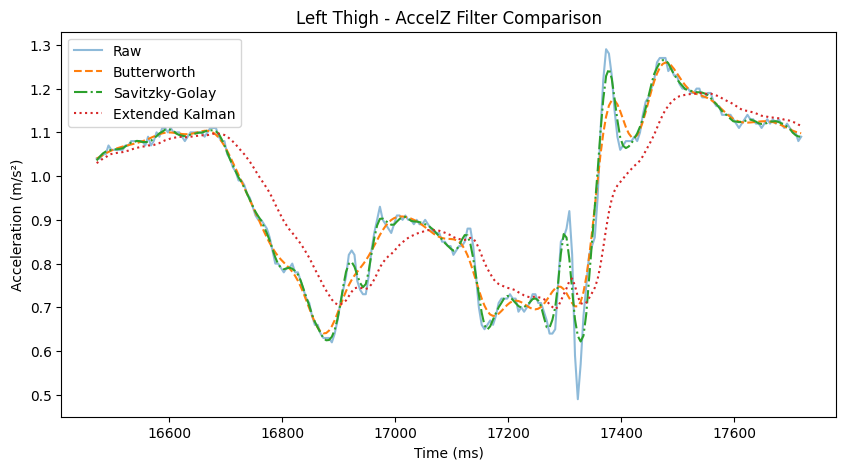

In [18]:
# Plot comparison of raw vs. filtered data for Left Thigh AccelZ
fig, ax = plt.subplots(figsize=(10, 5))
time = sensor_data["Left Thigh"]['Time(ms)']

ax.plot(time[:250], sensor_data["Left Thigh"]['AccelZ'][:250], label="Raw", alpha=0.5)
ax.plot(time[:250], filtered_data["Left Thigh"]['AccelZ_Butter'][:250], label="Butterworth", linestyle="--")
ax.plot(time[:250], filtered_data["Left Thigh"]['AccelZ_SavGol'][:250], label="Savitzky-Golay", linestyle="-.")
ax.plot(time[:250], filtered_data["Left Thigh"]['AccelZ_EKF'][:250], label="Extended Kalman", linestyle=":")

ax.set_title("Left Thigh - AccelZ Filter Comparison")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Acceleration (m/s²)")
ax.legend()
plt.show()


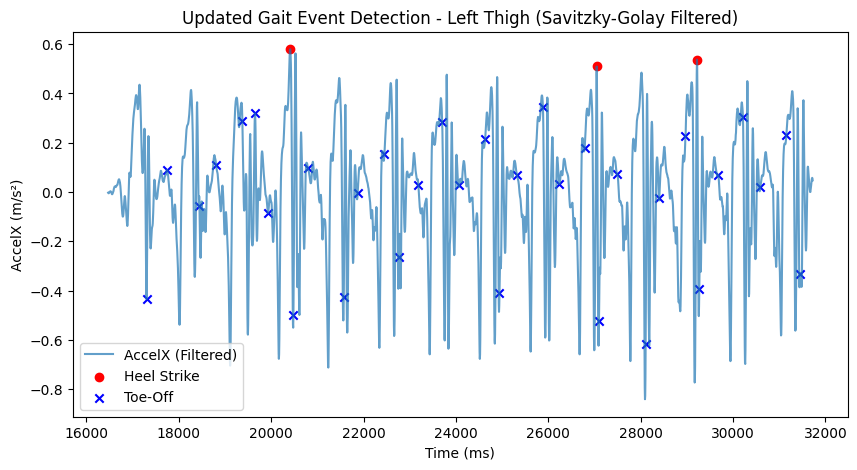

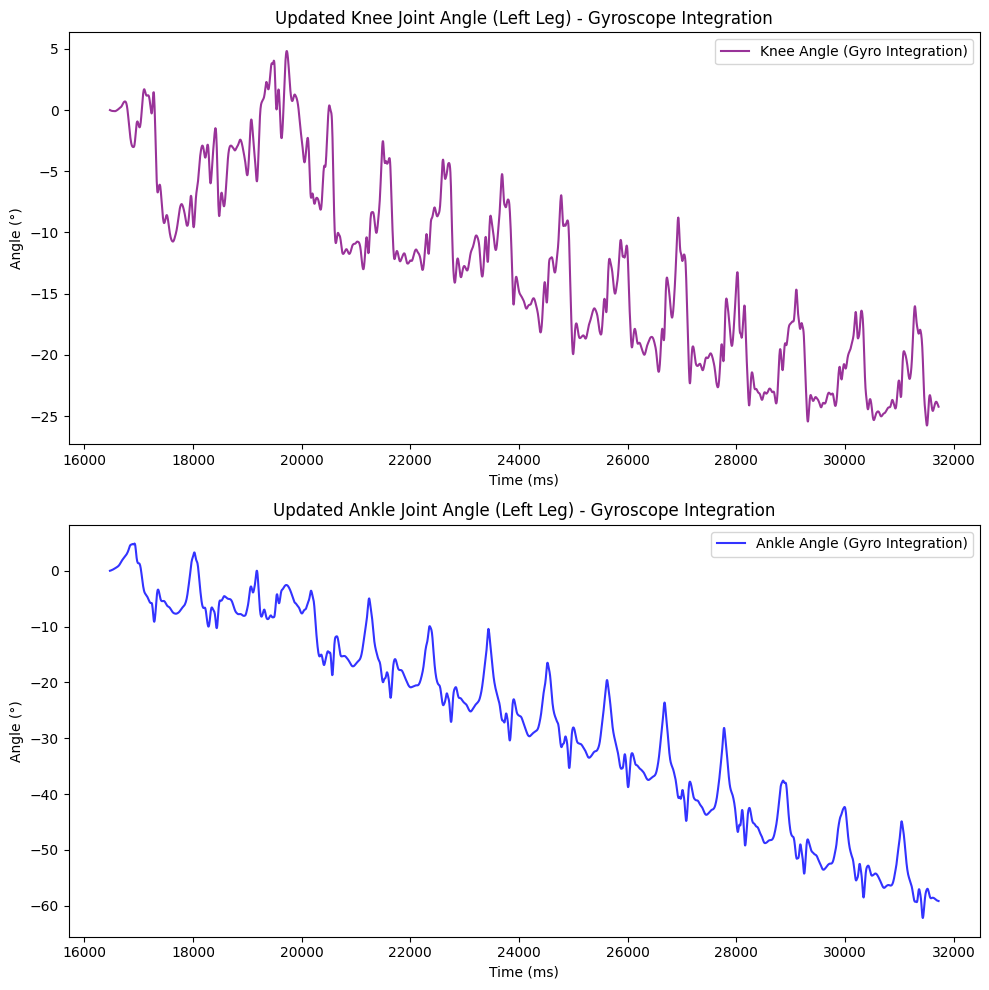

In [25]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Compute dt (time step between consecutive readings)
time = sensor_data["Left Thigh"]['Time(ms)'].values
dt = np.mean(np.diff(time)) / 1000  # Convert ms to seconds

# Function to integrate gyroscope data for angle estimation
def integrate_gyro(gyro, dt):
    return scipy.integrate.cumulative_trapezoid(gyro, dx=dt, initial=0)

# Use updated sensor orientation for gait event detection

# Extract filtered AccelX for Heel Strike detection (downward impact)
accel_x = filtered_data["Left Thigh"]['AccelX_SavGol'].values

# Extract filtered GyroY for Toe-Off detection (forward rotation)
gyro_y = filtered_data["Left Thigh"]['GyroY_SavGol'].values

# Detect Heel Strike (HS) - Peaks in AccelX (foot impacting ground)
heel_strike_peaks, _ = find_peaks(accel_x, height=0.5, distance=50)

# Detect Toe-Off (TO) - Valleys in GyroY (foot lifting off ground)
toe_off_peaks, _ = find_peaks(-gyro_y, height=-0.5, distance=50)

# Plot gait events using new reference axes
plt.figure(figsize=(10, 5))
plt.plot(time, accel_x, label="AccelX (Filtered)", alpha=0.7)
plt.scatter(time[heel_strike_peaks], accel_x[heel_strike_peaks], color='red', label="Heel Strike", marker="o")
plt.scatter(time[toe_off_peaks], accel_x[toe_off_peaks], color='blue', label="Toe-Off", marker="x")
plt.title("Updated Gait Event Detection - Left Thigh (Savitzky-Golay Filtered)")
plt.xlabel("Time (ms)")
plt.ylabel("AccelX (m/s²)")
plt.legend()
plt.show()

# Now update joint angle estimation using GyroX (flexion/extension)
gyro_thigh_x = filtered_data["Left Thigh"]['GyroX_SavGol'].values
gyro_shank_x = filtered_data["Left Shank"]['GyroX_SavGol'].values
gyro_ankle_x = filtered_data["Left Ankle"]['GyroX_SavGol'].values

# Integrate gyroscope data to estimate angles
thigh_angle = integrate_gyro(gyro_thigh_x, dt)  # Flexion/Extension from GyroX
shank_angle = integrate_gyro(gyro_shank_x, dt)
ankle_angle = integrate_gyro(gyro_ankle_x, dt)

# Compute knee and ankle angles
knee_angle = thigh_angle - shank_angle  # Knee flexion-extension
ankle_angle = shank_angle - ankle_angle  # Ankle dorsiflexion-plantarflexion

# Plot updated joint angles
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(time, knee_angle, label="Knee Angle (Gyro Integration)", color='purple', alpha=0.8)
ax[0].set_title("Updated Knee Joint Angle (Left Leg) - Gyroscope Integration")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Angle (°)")
ax[0].legend()

ax[1].plot(time, ankle_angle, label="Ankle Angle (Gyro Integration)", color='blue', alpha=0.8)
ax[1].set_title("Updated Ankle Joint Angle (Left Leg) - Gyroscope Integration")
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Angle (°)")
ax[1].legend()

plt.tight_layout()
plt.show()


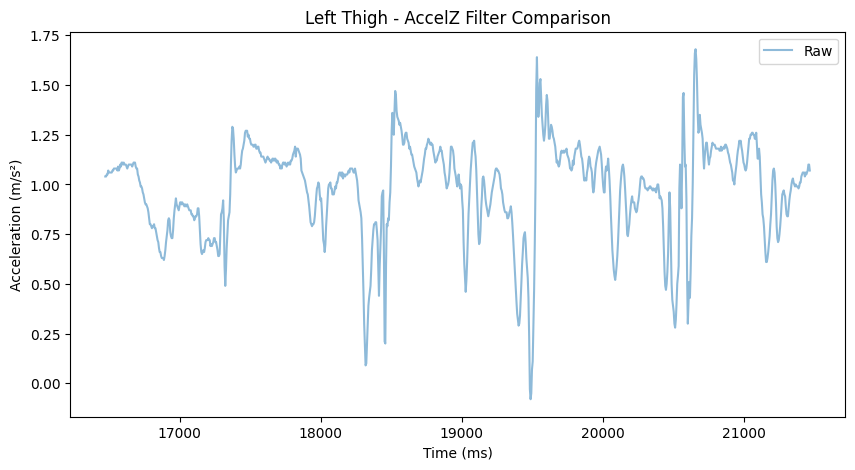

In [ ]:
# Plot comparison of raw vs. filtered data for Left Thigh AccelZ
fig, ax = plt.subplots(figsize=(10, 5))
time = sensor_data["Left Shank"]['Time(ms)']

ax.plot(time[:1000], sensor_data["Left Shank"]['AccelZ'][:1000], label="Raw", alpha=0.5)

ax.set_title("Left Shank - AccelZ Filter Comparison")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Acceleration (m/s²)")
ax.legend()
plt.show()
